<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/Anya_Maudy_CNN_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopdl

In [2]:
!pip install jcopml

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2, inception_v3, resnet18
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from jcopml.plot import plot_missing_value, plot_confusion_matrix

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from PIL import Image
import os

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
PATH = '/content/klasifikasi anya/'
images, labels = [], []
for dirname, _, filenames in os.walk(PATH):
  #if dirname.split('/')[-1] != "michelle":
  for filename in filenames:
    images.append(os.path.join(dirname, filename).split('/')[-1]) # /folder/blabla/xxx.jpg
    labels.append(os.path.join(dirname, filename).split('/')[-2])

In [6]:
label2cat = np.unique(labels)
label2cat

array(['anya', 'maudy'], dtype='<U5')

In [7]:
ints = np.arange(0, len(label2cat))
dicts = dict(zip(label2cat, ints))
dicts

{'anya': 0, 'maudy': 1}

In [8]:
datas = pd.DataFrame({'image_id':images, 'label':labels})
datas.head()

,image_id,label
0,85.jpg,maudy
1,289.jpg,maudy
2,41.jpg,maudy
3,123.jpg,maudy
4,743.jpg,maudy


In [9]:
datas.label.value_counts()

anya     598
maudy    410
Name: label, dtype: int64

In [10]:
index = []
for i in range(len(datas)):
    try:
        Image.open(PATH + str(datas['label'].values[i]) + '/' + str(datas['image_id'].values[i]))
        
    except PIL.UnidentifiedImageError:
        index.append(i)
  
    except FileNotFoundError:
        index.append(i)

datas = datas.drop(index)
datas.head(), datas.shape

(  image_id  label
 0   85.jpg  maudy
 1  289.jpg  maudy
 2   41.jpg  maudy
 3  123.jpg  maudy
 4  743.jpg  maudy, (1008, 2))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    datas['image_id'].values, datas['label'].values, 
    test_size=0.20, stratify=datas['label'].values, 
    random_state=24)

len(X_train), len(X_test)

(806, 202)

In [12]:
class customDataset(Dataset):
    def __init__(self, x, y, path, maps_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.dicts = maps_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx]))
        label = self.y[idx]
        label = self.label_2_ints(label)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label
    
    def label_2_ints(self, x):
        label_id = None
        for key, values in self.dicts.items():
            if x == key:
                label_id = values
        return label_id
    
    def __len__(self):
        return len(self.X)

In [13]:
crop_size = 224
bs = 64
train_transform = transforms.Compose([
    transforms.Resize(450),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(235),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_set = customDataset(X_train, y_train, PATH, transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = customDataset(X_test, y_test, PATH, transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [14]:
feature, target = next(iter(trainloader))
feature.shape, len(trainloader)

(torch.Size([64, 3, 224, 224]), 13)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

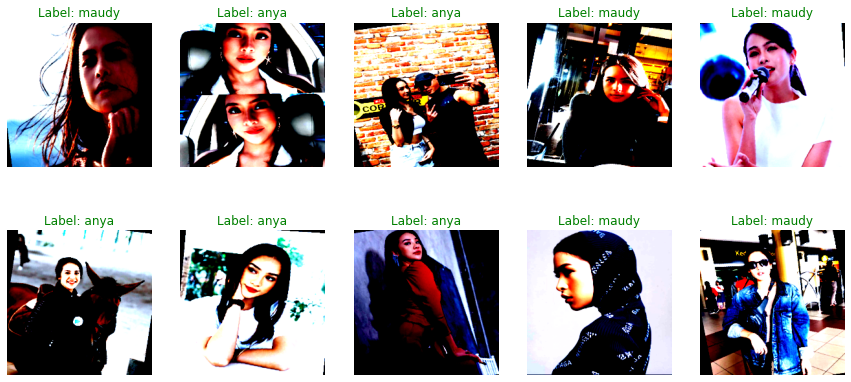

In [15]:
fig, axes = plt.subplots(2,5, figsize=(15, 7))
for img, label, ax in zip(feature, target, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'g'}
  label = label2cat[label.item()]
  ax.set_title(f"Label: {label}", fontdict=font);
  ax.axis("off");

In [16]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()
    #self.mnet.fc.in_features
    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(256, output_size),
        nn.LogSoftmax(1)
    )

  def forward(self, x):
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [17]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'output_size': len(label2cat)
})

In [18]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [19]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 0.7094 | Test_cost  = 0.6130 | Train_score = 0.5695 | Test_score = 0.7376 |




Epoch     2
Train_cost  = 0.5636 | Test_cost  = 0.5269 | Train_score = 0.7345 | Test_score = 0.7030 |
==> EarlyStop patience =  1 | Best test_score: 0.7376




Epoch     3
Train_cost  = 0.4810 | Test_cost  = 0.4622 | Train_score = 0.7816 | Test_score = 0.8020 |




Epoch     4
Train_cost  = 0.4435 | Test_cost  = 0.4393 | Train_score = 0.8065 | Test_score = 0.7970 |
==> EarlyStop patience =  1 | Best test_score: 0.8020




Epoch     5
Train_cost  = 0.3858 | Test_cost  = 0.4267 | Train_score = 0.8424 | Test_score = 0.7921 |
==> EarlyStop patience =  2 | Best test_score: 0.8020
==> Execute Early Stopping at epoch: 5 | Best test_score: 0.8020
==> Best model is saved at model


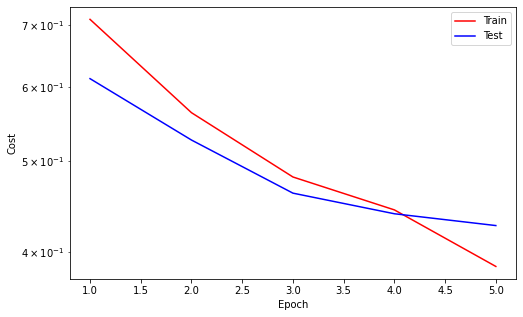

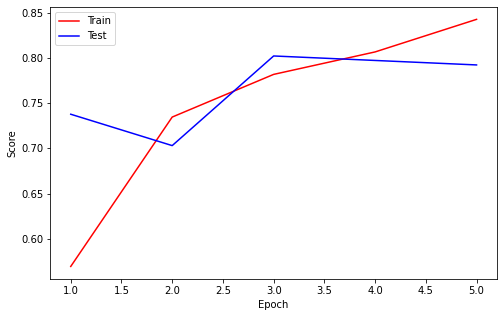

In [20]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break
    

In [22]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

callback.reset_early_stop()
callback.early_stop_patience = 6



Epoch    22
Train_cost  = 0.0078 | Test_cost  = 0.3118 | Train_score = 0.9988 | Test_score = 0.9307 |




Epoch    23
Train_cost  = 0.0063 | Test_cost  = 0.3141 | Train_score = 0.9988 | Test_score = 0.9158 |
==> EarlyStop patience =  1 | Best test_score: 0.9307




Epoch    24
Train_cost  = 0.0095 | Test_cost  = 0.3081 | Train_score = 0.9988 | Test_score = 0.9059 |
==> EarlyStop patience =  2 | Best test_score: 0.9307




Epoch    25
Train_cost  = 0.0119 | Test_cost  = 0.3493 | Train_score = 0.9963 | Test_score = 0.8762 |
==> EarlyStop patience =  3 | Best test_score: 0.9307




Epoch    26
Train_cost  = 0.0066 | Test_cost  = 0.4651 | Train_score = 0.9975 | Test_score = 0.8812 |
==> EarlyStop patience =  4 | Best test_score: 0.9307




Epoch    27
Train_cost  = 0.0054 | Test_cost  = 0.3576 | Train_score = 0.9988 | Test_score = 0.9109 |
==> EarlyStop patience =  5 | Best test_score: 0.9307




Epoch    28
Train_cost  = 0.0104 | Test_cost  = 0.3249 | Train_score = 0.9975 | Test_score = 0.9109 |
==> EarlyStop patience =  6 | Best test_score: 0.9307
==> Execute Early Stopping at epoch: 28 | Best test_score: 0.9307
==> Best model is saved at model


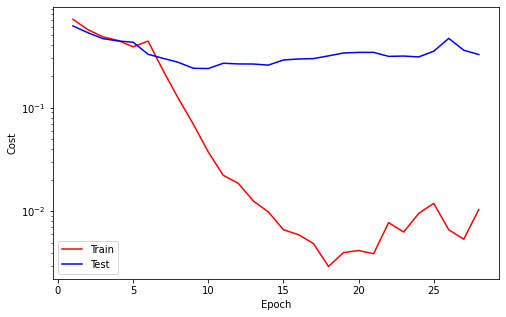

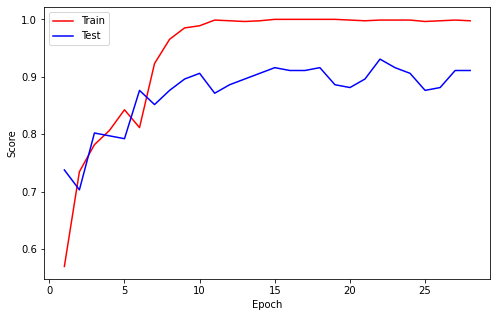

In [24]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

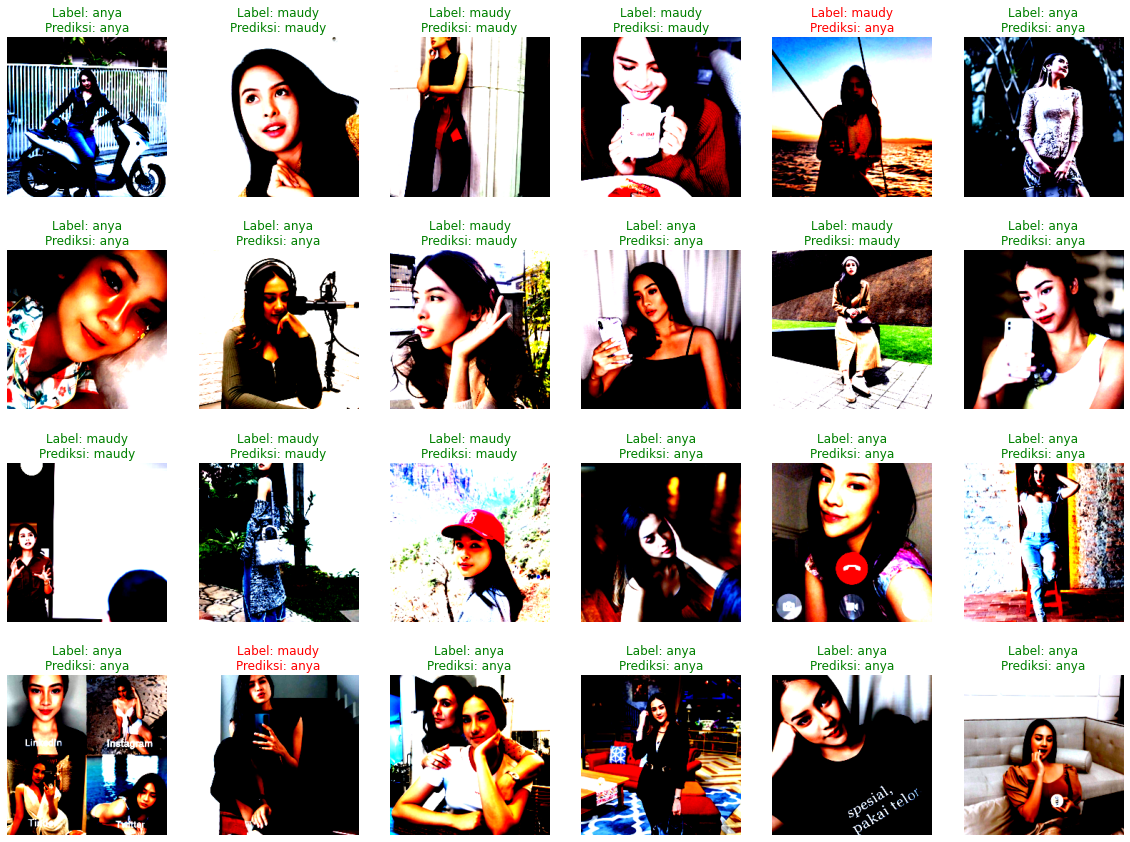

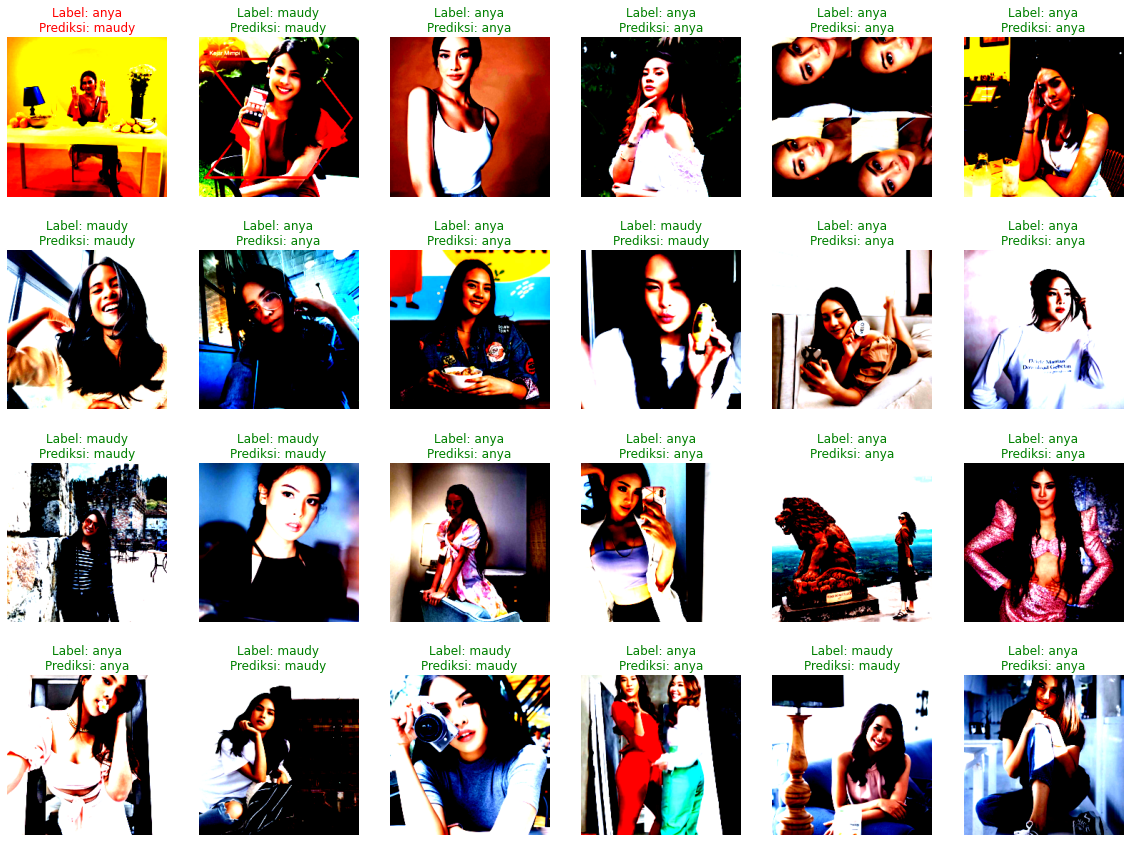

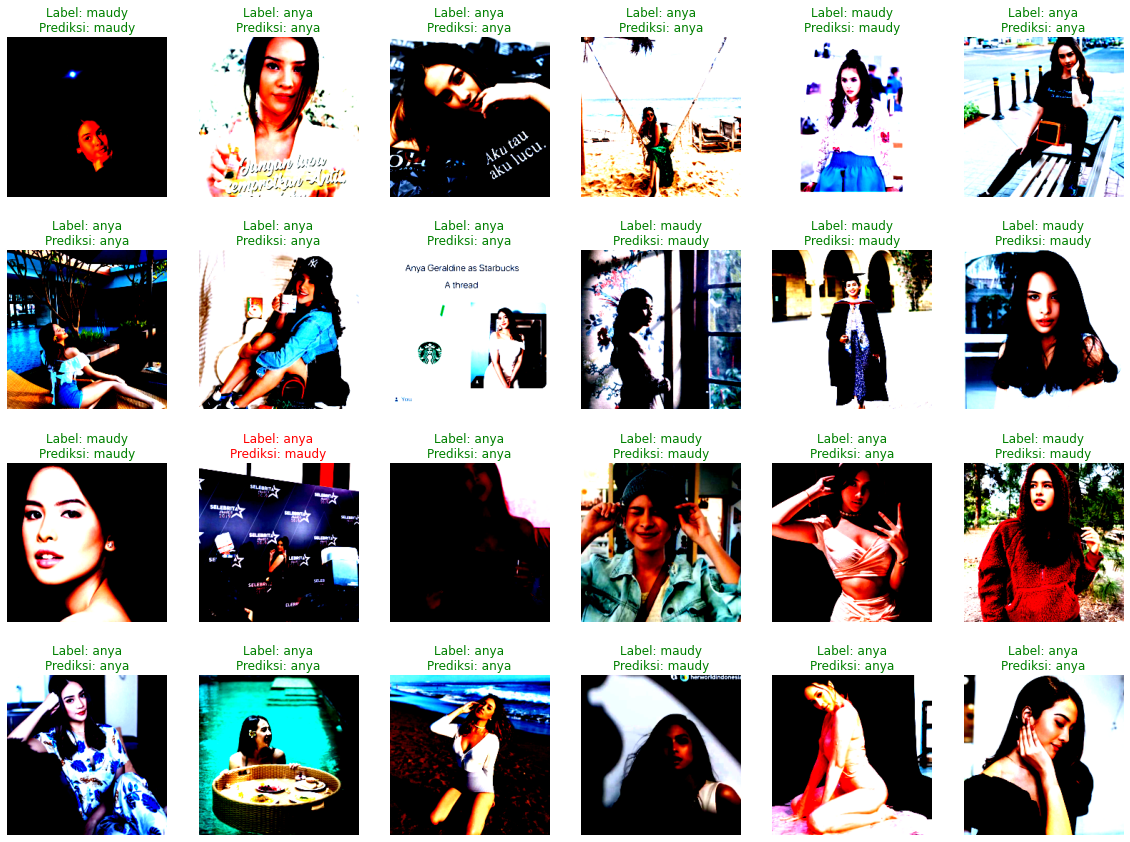

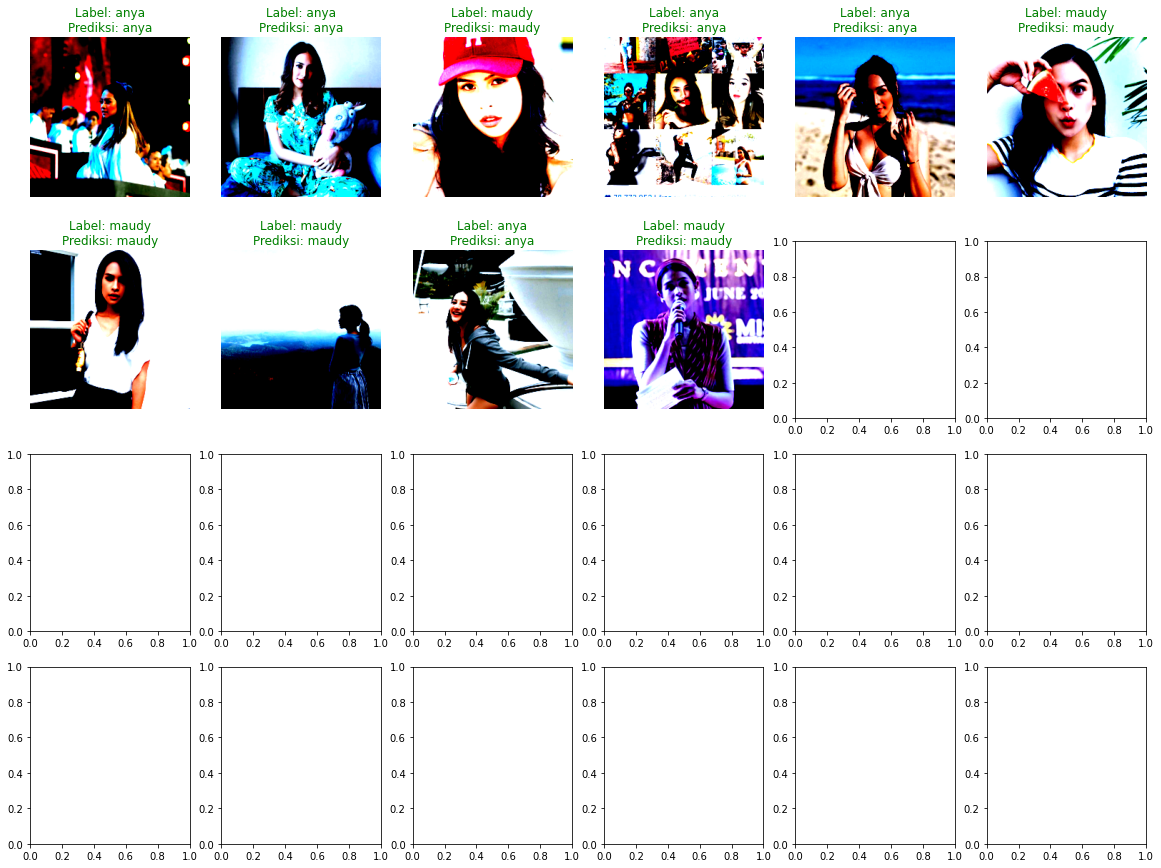

In [30]:
for feature, target in testloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

  fig, axes = plt.subplots(4, 6, figsize=(20, 15))
  for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color":'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label}\nPrediksi: {pred}", fontdict=font);
    ax.axis("off");